In [1]:
from databaseCommunication import readDatabaseFile, createDataFrame_list
from dataframeFormating import createLabeledDataFrame_list #, N_polarized_pure3b, N_polarized, N_linear, getReducedDataframe, getReducedResults, 
from dataframeFormating import polarizability, trapFrequency, add_aoh
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 

In [2]:
label_heads = ['latticeDetuning', 'initialCloud']
#labels = [[['-5'], [145294, ]]
#                 ]

#labels_TOF = [[['-5'], [145294, 145545]]]

labels_TOF = [[['-5', 'cold cloud'], [145564, 145611]],
              [['-5', 'cold cloud'], [145612, 145659]],
              [['-5', 'hot cloud'], [145677, 145772]]             
             ]


excluded = []
#excluded = list(df_TOF[df_TOF["yWidth"] > 50]["imageID"]) + list(df_TOF[df_TOF["xWidth"] > 50]["imageID"])

In [3]:
ciceroVariables = ['BECHoldTime', 'TOF', 'latticeDepth', 'ODT3_Comp', 'Y_rotation']
fitVariables = ['nCount', 'xWidth', 'yWidth']

"""df = createLabeledDataFrame_list(labels, label_heads, ciceroVariables, fitVariables)
for column in df.columns:
    try:
        df[column] = df[column].astype(float)
    except:
        pass
df['Y_rotation'] = df['Y_rotation'].astype(bool)
df.to_pickle('data_save_210428.pickle')"""

df_TOF_main = createLabeledDataFrame_list(labels_TOF, label_heads, ciceroVariables, fitVariables)
for column in df_TOF_main.columns:
    try:
        df_TOF_main[column] = df_TOF_main[column].astype(float)
    except:
        pass
df_TOF_main['Y_rotation'] = df_TOF_main['Y_rotation'].astype(bool)
df_TOF_main.to_pickle('data_save_210506_TOF.pickle')

In [4]:
"""df = pd.read_pickle('data_save_210428.pickle')
# Delete these row indexes from dataFrame
indexNames = pd.Index(np.where(df['imageID'].isin(excluded))[0])
df.drop(indexNames, inplace = True)"""

df_TOF_main = pd.read_pickle('data_save_210506_TOF.pickle')
# Delete these row indexes from dataFrame
indexNames = pd.Index(np.where(df_TOF_main['imageID'].isin(excluded))[0])
df_TOF_main.drop(indexNames, inplace = True)

In [18]:
df_TOF_main.head()
df_TOF_cold = df_TOF_main[df_TOF_main['initialCloud'] == "cold cloud"]
df_TOF_hot = df_TOF_main[df_TOF_main['initialCloud'] == "hot cloud"]

df_TOF = df_TOF_hot

In [19]:
latticeDepthList = df_TOF['latticeDepth'].unique()
Y_rotationList = df_TOF['Y_rotation'].unique()
BECHoldTimeList = df_TOF['BECHoldTime'].unique()
latticeDetuningList = df_TOF['latticeDetuning'].unique()

In [20]:
np.sort(latticeDepthList)

array([0.01, 0.02, 0.03, 0.05, 0.07, 0.1 , 0.15, 0.2 , 0.3 , 0.4 , 0.6 ,
       0.8 , 1.  , 1.25, 1.5 , 1.9 ])

In [21]:
def getRun(df, latticeDepth, Y_rotation = False, latticeDetuning = 25):
    df_temp = df[df['latticeDepth'] == latticeDepth]
    df_temp2 = df_temp[df_temp['Y_rotation'] == Y_rotation]
    df_temp2 = df_temp2[df_temp2['latticeDetuning'] == latticeDetuning]
    return df_temp

def getResult(dfResult, latticeDepth, Y_rotation, latticeDetuning = 25):
    df_temp = dfResult[dfResult['latticeDepth'] == latticeDepth]
    df_temp2 = df_temp[df_temp['Y_rotation'] == Y_rotation]
    df_temp3 = df_temp2[df_temp2['latticeDetuning'] == latticeDetuning]
    return df_temp3

Now let's look at the TOF series

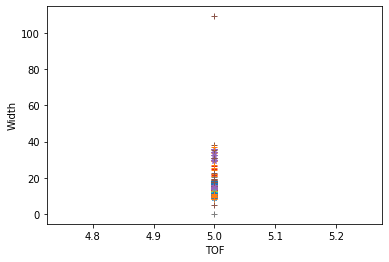

In [22]:
df_TOF
latticeDepthList_TOF = df_TOF['latticeDepth'].unique()

plt.figure()
for latticeDepth in latticeDepthList_TOF:
    df_run = getRun(df_TOF, latticeDepth, False, -5)
    plt.plot(df_run['TOF'], df_run['xWidth'], '*', label = 'Z')
    plt.plot(df_run['TOF'], df_run['yWidth'], '+', label = 'trans')
    
plt.xlabel("TOF")
plt.ylabel("Width")
#plt.legend()
plt.show()

In [61]:
def sigma(t, sigma0, v):
    return np.sqrt(sigma0**2+(v*t)**2)

def sigma(t, v):
    return v*t

def fitRun_sigma(df_run, XorY = 'xWidth'):
    #sigma0_guess = df_run[XorY].min()
    v_guess = df_run[XorY].max()/df_run['TOF'].max()
    popt, pcov = curve_fit(sigma, df_run['TOF'], df_run[XorY],
                       p0 = [v_guess]
                           #p0 = [sigma0_guess, v_guess]
                          )#bounds = ((0, 0), (np.inf, np.inf)),
                           #method = 'trf'
                      #)
    return popt, pcov

results_sigma = []
for latticeDetuning in latticeDetuningList:
    for latticeDepth in latticeDepthList:
        df_run = getRun(df_TOF, latticeDepth, Y_rotation = False, latticeDetuning = latticeDetuning)
        population = df_run['nCount'].mean()
        #print(latticeDetuning, latticeDepth)
        if not df_run.empty:
            print(latticeDepth)
            popt_Z, pcov_Z = fitRun_sigma(df_run, 'yWidth')
            print('xRun ok')
            popt_trans, pcov_trans = fitRun_sigma(df_run, 'xWidth')
            print('yRun ok')
            results_sigma += [{'latticeDetuning' : latticeDetuning,
                             'latticeDepth' : latticeDepth,
                             'Y_rotation' : False,
                            #'sigma0_Z' : popt_Z[0],
                            'v_Z' : popt_Z[0],
                            #'sigma0_trans' : popt_trans[0],
                            'v_trans' : popt_trans[0],
                            'nCount' : population*(6.5/4)**2
                        }]
resultsDF_sigma = pd.DataFrame(results_sigma)

1.5
xRun ok
yRun ok
1.0
xRun ok
yRun ok
1.9
xRun ok
yRun ok
0.6
xRun ok
yRun ok
0.07
xRun ok
yRun ok
0.01
xRun ok
yRun ok
0.4
xRun ok
yRun ok
0.03
xRun ok
yRun ok
0.15
xRun ok
yRun ok
0.3
xRun ok
yRun ok
1.25
xRun ok
yRun ok
0.2
xRun ok
yRun ok
0.8
xRun ok
yRun ok
0.02
xRun ok
yRun ok
0.1
xRun ok
yRun ok
0.05
xRun ok
yRun ok


In [62]:
resultsDF_sigma

,latticeDetuning,latticeDepth,Y_rotation,v_Z,v_trans,nCount
0,-5.0,1.50,False,6.114780,3.264987,106359.973958
1,-5.0,1.00,False,4.373950,2.945707,121641.710938
2,-5.0,1.90,False,7.916237,6.360320,102861.145833
3,-5.0,0.60,False,2.978147,2.703397,139462.408854
4,-5.0,0.07,False,2.106657,2.166747,151245.757812
5,-5.0,0.01,False,1.754758,1.893028,126180.945312
6,-5.0,0.40,False,3.256670,2.528180,140480.809896
7,-5.0,0.03,False,1.911998,2.034533,143327.403646
8,-5.0,0.15,False,2.684907,2.331923,165122.242188
9,-5.0,0.30,False,3.128453,2.485923,120226.776042


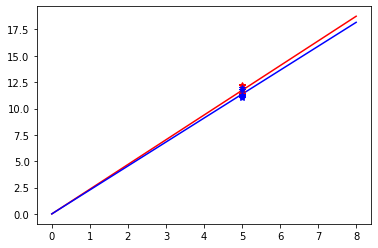

In [63]:
latticeDetuning = -5
latticeDepth = 0.1

tof = np.linspace(0, 8, 100)
df_run = getRun(df_TOF, latticeDepth, False, latticeDetuning)
df_res = getResult(resultsDF_sigma, latticeDepth, False, latticeDetuning)
#sigma0_Z, v_Z, sigma0_trans, v_trans = df_res.iloc[0,3:7]
v_Z, v_trans = df_res.iloc[0,3:5]
#sigma0_Z, v_Z = 8, 4
#sigma_Z_fit = sigma(tof, sigma0_Z, v_Z)
#sigma_trans_fit = sigma(tof, sigma0_trans, v_trans)
sigma_Z_fit = sigma(tof, v_Z)
sigma_trans_fit = sigma(tof, v_trans)

plt.figure()
plt.plot(tof, sigma_Z_fit, 'r-')
plt.plot(tof, sigma_trans_fit, 'b-')
plt.plot(df_run['TOF'], df_run['yWidth'], 'r*')
plt.plot(df_run['TOF'], df_run['xWidth'], 'b*')
#plt.ylim(0,2*max(sigma_Z_fit))
plt.show()

In [64]:
df_TOF[df_TOF["latticeDepth"] == 0.1]

,BECHoldTime,TOF,latticeDepth,ODT3_Comp,Y_rotation,nCount,xWidth,yWidth,imageID,latticeDetuning,initialCloud
124,5.0,5.0,0.1,0.0,False,63894.0,11.1617,12.1198,145705.0,-5.0,hot cloud
137,0.0,5.0,0.1,0.0,False,42451.0,10.9955,11.2974,145718.0,-5.0,hot cloud
142,5.0,5.0,0.1,0.0,False,35268.0,11.0897,12.2222,145723.0,-5.0,hot cloud
167,0.0,5.0,0.1,0.0,False,46029.0,11.2698,11.3417,145748.0,-5.0,hot cloud
183,5.0,5.0,0.1,0.0,False,41881.0,11.7104,11.7715,145764.0,-5.0,hot cloud
190,0.0,5.0,0.1,0.0,False,77260.0,11.9330,11.5737,145771.0,-5.0,hot cloud


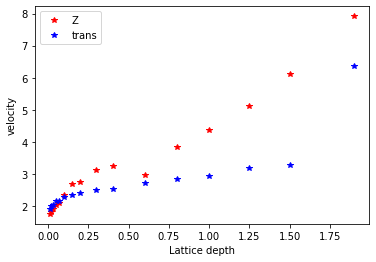

In [65]:
plt.figure()
plt.plot(resultsDF_sigma['latticeDepth'], resultsDF_sigma['v_Z'], 'r*', label = 'Z')
plt.plot(resultsDF_sigma['latticeDepth'], resultsDF_sigma['v_trans'], 'b*', label = 'trans')
plt.legend()
#plt.ylim(0, 5)
plt.ylabel("velocity")
plt.xlabel("Lattice depth")
plt.show()


# add velocity scale = hbar*k // recoil temperature

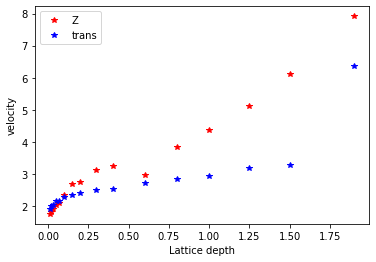

In [66]:
plt.figure()
plt.plot(resultsDF_sigma['latticeDepth'], resultsDF_sigma['v_Z'], 'r*', label = 'Z')
plt.plot(resultsDF_sigma['latticeDepth'], resultsDF_sigma['v_trans'], 'b*', label = 'trans')
plt.legend()
#plt.ylim(0, 5)
plt.ylabel("velocity")
plt.xlabel("Lattice depth")
plt.show()


# add velocity scale = hbar*k // recoil temperature

Calculate the velocity to temperature conversion. Here $\sigma = \sqrt{\sigma_0^{2}+(\sigma_{v}t)^{2}}$ is fitted from a gaussian distribution $\exp(-\frac{1}{2}\frac{x^{2}}{\sigma^{2}})$ where $x = vt$, so $v$ is distributed like a gaussian with width $\sigma_{v}$ which is the result of the fit $P(v) \sim \exp(-\frac{1}{2}\frac{v^{2}}{\sigma_{v}^{2}}) \sim \exp(-\frac{\frac{1}{2}mv^{2}}{k_{B}T})$. Therefore we find:
\[ \sigma_{v} = \sqrt{\frac{k_{B}T}{m}}\]

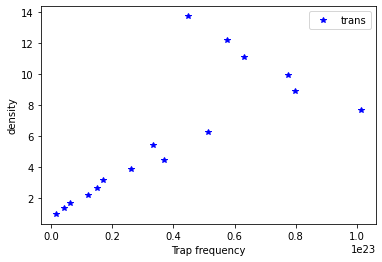

In [68]:
m_Dy = 164*1.66*10**(-27)
k_B = 1.38*10**(-23)
pixel_size = 6.5*10**(-6)
tof_unit = 10**(-3)
magnification = 4
resultsDF_sigma['temperature_Z'] = m_Dy*(resultsDF_sigma['v_Z']*pixel_size/magnification/tof_unit)**2/k_B
resultsDF_sigma['temperature_trans'] = m_Dy*(resultsDF_sigma['v_trans']*pixel_size/magnification/tof_unit)**2/k_B
resultsDF_sigma['trapFrequency'] = trapFrequency(resultsDF_sigma['latticeDetuning'], resultsDF_sigma['latticeDepth']*0.073)
resultsDF_sigma['transverseSize'] = np.sqrt(k_B*resultsDF_sigma['temperature_Z']/(m*(160*resultsDF_sigma['trapFrequency'])**2))
resultsDF_sigma['latticeSize'] = np.sqrt(hbar/(m*2*np.pi*10**3*resultsDF_sigma['trapFrequency']))
resultsDF_sigma['density'] = resultsDF_sigma['nCount']/(resultsDF_sigma['transverseSize']**2*resultsDF_sigma['latticeSize'])
plt.figure()
plt.plot(resultsDF_sigma['density'], resultsDF_sigma['trapFrequency'], 'b*', label = 'trans')
plt.legend()
#plt.ylim(0, 5)
plt.ylabel("density")
plt.xlabel("Trap frequency")
plt.show()

In [69]:
resultsDF_sigma

,latticeDetuning,latticeDepth,Y_rotation,v_Z,v_trans,nCount,temperature_Z,temperature_trans,trapFrequency,transverseSize,latticeSize,density
0,-5.0,1.50,False,6.114780,3.264987,106359.973958,1.947786e-06,5.553188e-07,12.188212,0.000005,7.112556e-08,5.759132e+22
1,-5.0,1.00,False,4.373950,2.945707,121641.710938,9.966145e-07,4.520210e-07,9.951634,0.000004,7.871337e-08,7.754634e+22
2,-5.0,1.90,False,7.916237,6.360320,102861.145833,3.264504e-06,2.107354e-06,13.717380,0.000006,6.704403e-08,4.465624e+22
3,-5.0,0.60,False,2.978147,2.703397,139462.408854,4.620318e-07,3.807142e-07,7.708502,0.000004,8.943566e-08,1.012699e+23
4,-5.0,0.07,False,2.106657,2.166747,151245.757812,2.311890e-07,2.445659e-07,2.632955,0.000008,1.530291e-07,1.496562e+22
5,-5.0,0.01,False,1.754758,1.893028,126180.945312,1.604036e-07,1.866782e-07,0.995163,0.000018,2.489135e-07,1.580468e+21
6,-5.0,0.40,False,3.256670,2.528180,140480.809896,5.524934e-07,3.329627e-07,6.293966,0.000005,9.897682e-08,5.138909e+22
7,-5.0,0.03,False,1.911998,2.034533,143327.403646,1.904384e-07,2.156299e-07,1.723673,0.000011,1.891334e-07,5.970108e+21
8,-5.0,0.15,False,2.684907,2.331923,165122.242188,3.755242e-07,2.832749e-07,3.854251,0.000007,1.264811e-07,2.607880e+22
9,-5.0,0.30,False,3.128453,2.485923,120226.776042,5.098459e-07,3.219252e-07,5.450734,0.000006,1.063575e-07,3.326364e+22


In [33]:
kappa_red = (1/2)*(1+1/153)
hbar = 1.0545718*10**-34
c = 2.99792458*10**8
polarizability_0 = 1.64877727*10**(-41)
m = 163.929*1.66053906660*10**(-27)
epsilon_0 = 8.85418782*10**(-12)
k_B = 1.38064852*10**(-23)
a_0 = 5.29177210903*10**(-11)
mu_B = 9.274009994*10**(-24)
Gamma_741 = 2*np.pi*1.78*10**3   # in Hz
omega_741 = 2*np.pi*c/(741*10**(-9))
Gamma_421 = 2*np.pi*32.2*10**6
omega_421 = 2*np.pi*c/(421.172*10**(-9))
delta_421 = omega_421 - omega_741
omega_405 = 2*np.pi*c/(404.597*10**(-9))
omega_419 = 2*np.pi*c/(418.682*10**(-9))
omega_419_bis = 2*np.pi*c/(419.484*10**(-9))
Gamma_405 = 1.92*10**8
Gamma_419 = 1.26*10**8
Gamma_419_bis = 8.8*10**7
kappa_blue = (1/2)*((1+1/153)+(1/9)*(Gamma_419/Gamma_421)**2
                                 *(omega_421/omega_419)**6
                                 +(1/9)*(Gamma_419_bis/Gamma_421)**2
                                 *(omega_421/omega_419_bis)**6
                                 +(15/17)*(Gamma_405/Gamma_421)**2
                                 *(omega_421/omega_405)**6)
polarizability_prefactor = 3*np.pi*kappa_red*epsilon_0*c**3*Gamma_741/(omega_741**3)
add =m/2 * (1/(epsilon_0*c**2))/(4*np.pi)*(10*mu_B/hbar)**2
gamma_blue_prefactor = 3*kappa_blue*c**2*Gamma_421**2/(hbar*delta_421**2*omega_421**3)*(421/741)**3
gamma_red_prefactor = 3*kappa_red*c**2*Gamma_741**2/(hbar*omega_741**3)

beamwaist = 27

def polarizability(detuning):
    polarizability_prefactor = 3*np.pi*kappa_red*epsilon_0*c**3*Gamma_741/(omega_741**3)
    polarizability = 220*polarizability_0-polarizability_prefactor/detuning
    return polarizability

def trapFrequency(detuning, power):
    polarizability_here = polarizability(detuning)
    omega_z = np.sqrt(np.abs(32*np.pi*polarizability_here*power/((741*10**(-9))**2*beamwaist**2*epsilon_0*c*m)))
    trapFrequency = omega_z/(2*np.pi*10**3)
    return trapFrequency
    
def updateTrapDepth(self):
    omega_z = self.trapFrequency*(2*np.pi*10**3)
    self.trapDepth = self.m**2*omega_z**2/(self.hbar**2*(self.omega_741/self.c)**4)
    
def add_aoh(detuning, power):
    omega_z = trapFrequency(detuning, power)*(2*np.pi*10**3)
    oscillator_length = np.sqrt(hbar/(m/2*omega_z))
    add_aoh = add/oscillator_length
    return add_aoh
    
def updateScattering(self):
    gamma_blue = self.gamma_blue_prefactor*self.power/self.beamwaist**2
    gamma_red = self.gamma_red_prefactor/(self.detuning**2)*self.power/self.beamwaist**2
    self.scattering = gamma_blue + gamma_red